In [1]:
import sys
sys.path.append('/global/homes/j/jpiat/shared_code/abacus_mocks/')

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from hodpy.k_correction import GAMA_KCorrection
from hodpy import lookup
from hodpy.cosmology import CosmologyAbacus
from scipy.interpolate import CubicSpline
from gravitational_redshift import z_grav

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})

cosmo = CosmologyAbacus(0)  #c000 cosmology
kcorr_r = GAMA_KCorrection(cosmo, k_corr_file=lookup.kcorr_file, cubic_interpolation=True)

In [14]:
cosmo.comoving_distance(0.37)

array(1008.50232943)

In [2]:
def apparent_mag(M,z,g_r,Q=0.8):
    
    K = kcorr_r.apparent_magnitude(M, z, g_r)
    EC = Q*(z - 0.1)
    
    return K - EC

In [3]:
file = '/global/cfs/cdirs/desi/users/sbrieden/abacus/Ab_c000_ph006/z0.200/BGS_SecondGen/cutsky_BGS_z0.200_AbacusSummit_base_c000_ph006_pot.fits'

m_lim = 19.5   # BGS magnitude cut
n_bins = 20    # number of redshift bins
z_max = 0.5    # max redshift

In [4]:
sky = fits.open(file)
data = sky[1].data
sky.close()


m_app = data['R_MAG_APP']
M = data['R_MAG_ABS']
g_r = data['G_R_REST']
ra = data['RA']
dec = data['DEC']

z_cos = data['Z_COSMO']    
z = data['Z']
phi = data['Pot A Soft 7']
#phi0 = phi[z_cos==np.min(z_cos)]
phi0 = 0
z_tot = z_grav(z_cos, z, phi, phi0)

m_tot = apparent_mag(M,z_tot,g_r)

In [5]:
cond = (np.isnan(m_tot)==False)*(m_tot<=m_lim)*(z_tot<=z_max)
m = m_tot[cond]
z_g = z_tot[cond]
z_cos = z_cos[cond]

0.19545615


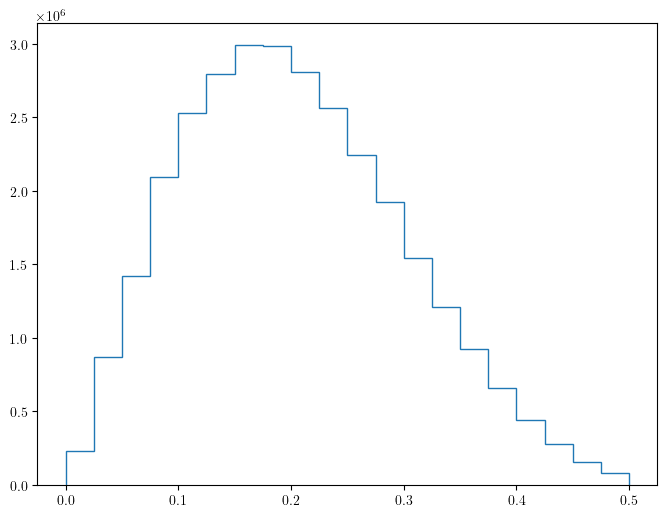

In [6]:
zbins = np.linspace(0, 0.5, n_bins+1)

print(np.median(z_g))

plt.figure(figsize=(8,6))
plt.hist(z_g,bins=zbins,histtype='step');

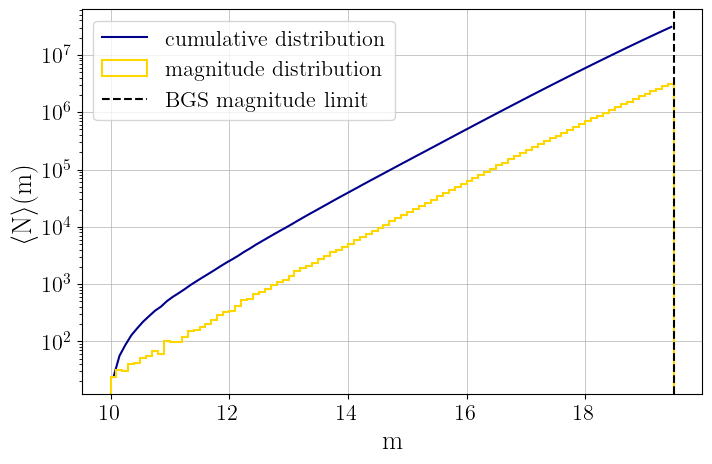

In [7]:
dm = 1
mbins = np.arange(100,195+dm,dm)/10  # float representation error
nm,_ = np.histogram(m,bins=mbins)
cnm = np.cumsum(nm)
mcen = mbins[:-1]+dm/20


plt.figure(figsize=(8,5))
plt.grid(zorder=0,lw=0.5)
plt.xticks(fontsize = 16) 
plt.yticks(fontsize = 16) 
plt.yscale('log')
plt.xlabel('m',fontsize=20)
plt.ylabel(r'$\langle \rm N \rangle (m)$',fontsize=20)
plt.plot(mcen,cnm,lw=1.5,c='darkblue',label='cumulative distribution')
plt.hist(m,bins=mbins,lw=1.5,color='gold',histtype='step',label='magnitude distribution')
plt.axvline(m_lim, ls='--', lw =1.5, color='k',label='BGS magnitude limit')
plt.legend(fontsize=16);
plt.savefig('/global/homes/j/jpiat/Relativistic_effects/figures/dist_m.pdf')

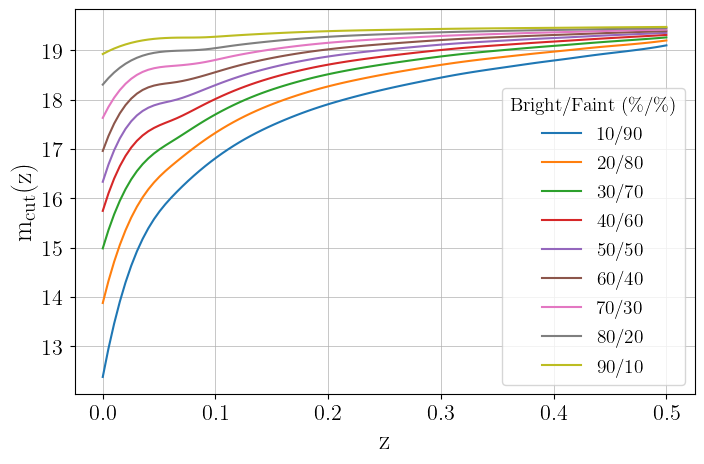

In [8]:
cut_bright = [10,20,30,40,50,60,70,80,90]
cut_faint = [90,80,70,60,50,40,30,20,10]


plt.figure(figsize=(8,5))
plt.grid(zorder=0,lw=0.5)
plt.xticks(fontsize = 16) 
plt.yticks(fontsize = 16) 
plt.xlabel('z',fontsize=20)
plt.ylabel(r'm$_{\rm cut}$(z)',fontsize=20)


for cut_b, cut_f in zip(cut_bright, cut_faint):

    z_bins = np.linspace(0, np.max(z_g), n_bins+1)
    
    z_means = np.zeros(n_bins)
    m_cuts_b = np.zeros(n_bins)
    m_cuts_f = np.zeros(n_bins)
        
    for i in range(n_bins):
        if i==(n_bins-1):
            bin = (z_g>=z_bins[i])*(z_g<=z_bins[i+1])
        else:
            bin = (z_g>=z_bins[i])*(z_g<z_bins[i+1])
    
        mi = m[bin]
        zi = z_g[bin]
        
        z_means[i] = np.mean(zi)
        
        m_cut_b = np.percentile(mi,cut_b)
        m_cut_f = np.percentile(mi,100-cut_f)
        m_cuts_b[i] = m_cut_b
        m_cuts_f[i] = m_cut_f
    
    
    m_int_b = CubicSpline(z_means, m_cuts_b, extrapolate=True)
    m_int_f = CubicSpline(z_means, m_cuts_f, extrapolate=True)
    
    z_plot = np.linspace(0, 0.5, 100)
    plt.plot(z_plot, m_int_b(z_plot),label=f'{cut_b}/{cut_f}')
    
plt.legend(fontsize=14,title='Bright/Faint (\%/\%)',title_fontsize=14)   #,fancybox=True)
plt.savefig('/global/homes/j/jpiat/Relativistic_effects/figures/m_cut.pdf')

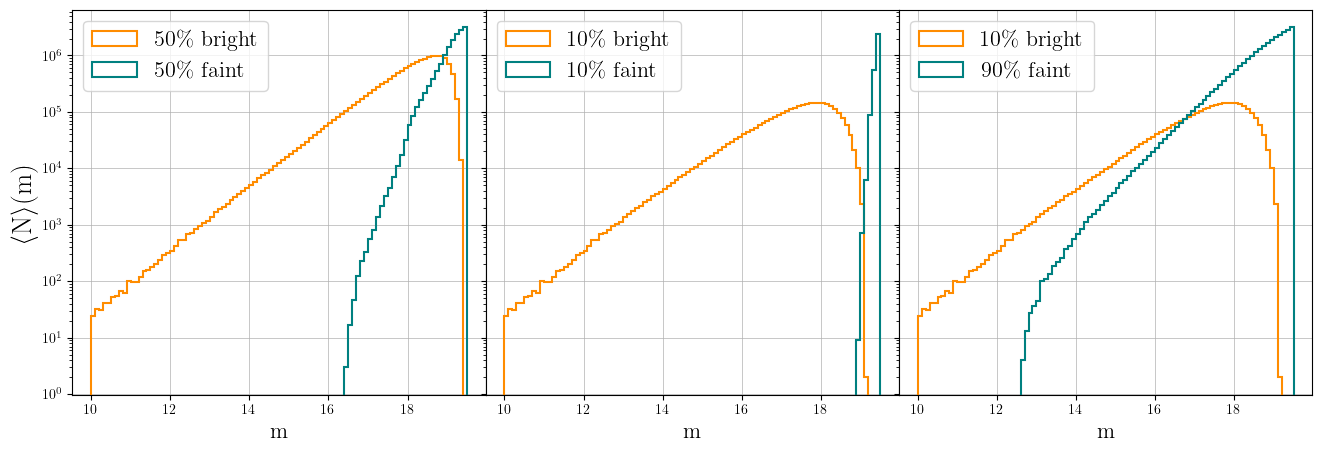

In [9]:
cut_bright = [50,10,10]
cut_faint = [50,10,90]

dm = 1
mbins = np.arange(100,195+dm,dm)/10  # float representation error
mcen = mbins[:-1]+dm/20


fig, axes = plt.subplots(nrows=1, ncols=3, sharey =True, figsize=(16, 5))
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.subplots_adjust(wspace=0)
axes[1].set_xlabel('m',fontsize=20)
axes[0].set_ylabel(r'$\langle\rm N \rangle (m)$',fontsize=20)

colors = ['darkorange','teal']

for j,(cut_b, cut_f) in enumerate(zip(cut_bright, cut_faint)):

    z_bins = np.linspace(0, 0.5, n_bins+1)
    
    z_means = np.zeros(n_bins)
    m_cuts_b = np.zeros(n_bins)
    m_cuts_f = np.zeros(n_bins)
        
    for i in range(n_bins):
        if i==(n_bins-1):
            bin = (z_g>=z_bins[i])*(z_g<=z_bins[i+1])
        else:
            bin = (z_g>=z_bins[i])*(z_g<z_bins[i+1])
    
        mi = m[bin]
        zi = z_g[bin]
        
        z_means[i] = np.mean(zi)
        
        m_cut_b = np.percentile(mi,cut_b)
        m_cut_f = np.percentile(mi,100-cut_f)
        m_cuts_b[i] = m_cut_b
        m_cuts_f[i] = m_cut_f
    
    
    m_int_b = CubicSpline(z_means, m_cuts_b, extrapolate=True)
    m_int_f = CubicSpline(z_means, m_cuts_f, extrapolate=True)
    
    cond_b = (m<=m_int_b(z_g))
    cond_f = (m>m_int_f(z_g))
    
    m_b = m[cond_b]
    m_f = m[cond_f]
    
    axes[j].grid(zorder=0,lw=0.5)
    axes[j].set_yscale('log')
    axes[j].set_xlabel('m',fontsize=16)
    
    axes[j].hist(m_b,bins=mbins,color=colors[0],lw=1.5,histtype='step',label=f'{cut_b}'+'\% bright')
    axes[j].hist(m_f,bins=mbins,color=colors[1],lw=1.5,histtype='step',label=f'{cut_f}'+'\% faint')
    axes[j].legend(fontsize=16)
    
plt.savefig('/global/homes/j/jpiat/Relativistic_effects/figures/dist_m_samp.pdf');

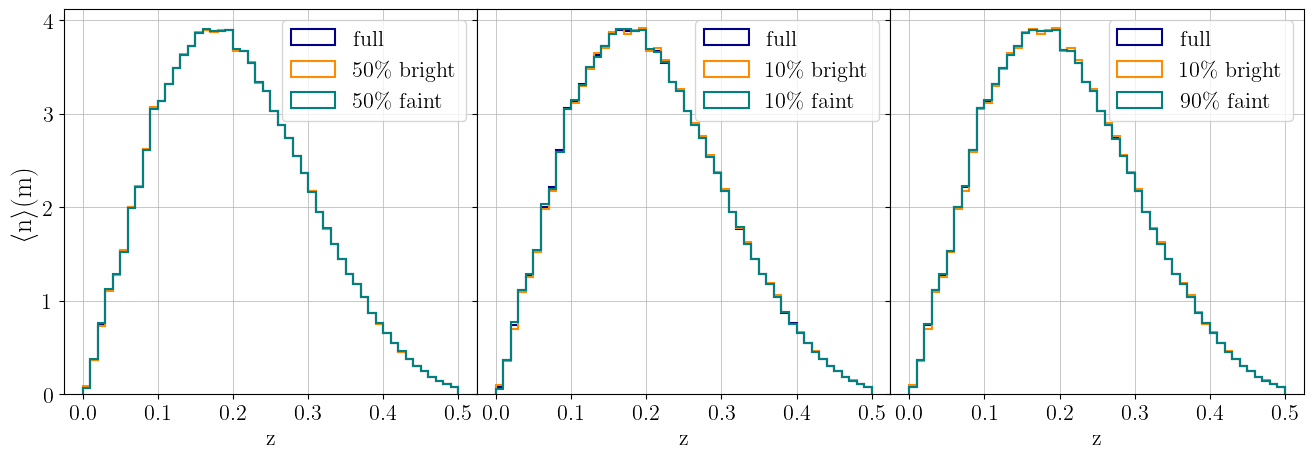

In [10]:
dm = 0.1
zbins = np.arange(0,5+dm,dm)/10  # float representation error

cut_bright = [50,10,10]
cut_faint = [50,10,90]

dm = 1
mbins = np.arange(120,195+dm,dm)/10  # float representation error
mcen = mbins[:-1]+dm/20


fig, axes = plt.subplots(nrows=1, ncols=3, sharey =True, figsize=(16, 5))
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.subplots_adjust(wspace=0)
axes[1].set_xlabel('m',fontsize=20)
axes[0].set_ylabel(r'$\langle\rm n \rangle  (m)$',fontsize=20)

colors = ['darkorange','teal']

for j,(cut_b, cut_f) in enumerate(zip(cut_bright, cut_faint)):

    z_bins = np.linspace(0, 0.5, n_bins+1)
    
    z_means = np.zeros(n_bins)
    m_cuts_b = np.zeros(n_bins)
    m_cuts_f = np.zeros(n_bins)
        
    for i in range(n_bins):
        if i==(n_bins-1):
            bin = (z_g>=z_bins[i])*(z_g<=z_bins[i+1])
        else:
            bin = (z_g>=z_bins[i])*(z_g<z_bins[i+1])
    
        mi = m[bin]
        zi = z_g[bin]
        
        z_means[i] = np.mean(zi)
        
        m_cut_b = np.percentile(mi,cut_b)
        m_cut_f = np.percentile(mi,100-cut_f)
        m_cuts_b[i] = m_cut_b
        m_cuts_f[i] = m_cut_f
    
    
    m_int_b = CubicSpline(z_means, m_cuts_b, extrapolate=True)
    m_int_f = CubicSpline(z_means, m_cuts_f, extrapolate=True)
    
    cond_b = (m<=m_int_b(z_g))
    cond_f = (m>m_int_f(z_g))
    
    z_b = z_g[cond_b]
    z_f = z_g[cond_f]
    
    axes[j].grid(zorder=0,lw=0.5)

    axes[j].set_xlabel('z',fontsize=16)
    
    axes[j].hist(z_g,bins=zbins,color='darkblue',lw=1.5,density=True,histtype='step',label='full')
    axes[j].hist(z_b,bins=zbins,color=colors[0],lw=1.5,density=True,histtype='step',label=f'{cut_b}'+'\% bright')
    axes[j].hist(z_f,bins=zbins,color=colors[1],lw=1.5,density=True,histtype='step',label=f'{cut_f}'+'\% faint')
    axes[j].legend(fontsize=16)
    
plt.savefig('/global/homes/j/jpiat/Relativistic_effects/figures/dist_z_samp.pdf');

In [12]:
def s_eff(m,z_g,cut_b,cut_f):
    
    z_bins = np.linspace(0, 0.5, n_bins+1)
    z_means = np.zeros(n_bins)
    m_cuts_b = np.zeros(n_bins)
    m_cuts_f = np.zeros(n_bins)
    s_b = np.zeros(n_bins)
    s_f = np.zeros(n_bins)
    s_ = np.zeros(n_bins)
    s_b_eff = 0
    s_f_eff = 0
    s_eff = 0
    N_b = np.zeros(n_bins)
    N_f = np.zeros(n_bins)
    N_ = np.zeros(n_bins)
    
    
    for i in range(n_bins):
        if i==(n_bins-1):
            bin = (z_g>=z_bins[i])*(z_g<=z_bins[i+1])
        else:
            bin = (z_g>=z_bins[i])*(z_g<z_bins[i+1])
    
        mi = m[bin]
        zi = z_g[bin]
        
        z_means[i] = np.mean(zi)
        
        m_cut_b = np.percentile(mi,cut_b)
        m_cut_f = np.percentile(mi,100-cut_f)
        m_cuts_b[i] = m_cut_b
        m_cuts_f[i] = m_cut_f
        
        # compute magnification bias
        
        mi_b = mi[mi<=m_cut_b]
        mi_f = mi[mi>m_cut_f]
        
        n_b,bins_b = np.histogram(mi_b,bins=50)
        cn_b = np.cumsum(n_b)
        centres_b = (bins_b[1:]+bins_b[:-1])/2
        si_b = (np.log10(cn_b[-1])-np.log10(cn_b[-2]))/(centres_b[-1]-centres_b[-2])
        s_b[i] = si_b
        
        n,bins = np.histogram(mi,bins=50)
        cn = np.cumsum(n)
        centres = (bins[1:]+bins[:-1])/2
        si = (np.log10(cn[-1])-np.log10(cn[-2]))/(centres[-1]-centres[-2])
        
        if (cut_b + cut_f) != 100:
       
            mi_ =  mi[mi<=m_cut_f]
            n_,bins_ = np.histogram(mi_,bins=50)
            cn_ = np.cumsum(n_)
            centres_ = (bins_[1:]+bins_[:-1])/2
            si_ = (np.log10(cn_[-1])-np.log10(cn_[-2]))/(centres_[-1]-centres_[-2])
            
            si_f = si*len(mi)/len(mi_f)-si_*len(mi_)/len(mi_f)
            
            s_[i] = si_
            s_f[i] = si_f
            
            s_eff += len(mi_)*si_
            N_[i] = len(mi_)
       
        else:
            si_f = si*len(mi)/len(mi_f)-si_b*len(mi_b)/len(mi_f)
            s_f[i] = si_f
              
        
        s_b_eff += len(mi_b)*si_b
        s_f_eff += len(mi_f)*si_f
        
        N_b[i] = len(mi_b)
        N_f[i] = len(mi_f)
        
    
    Nb_tot = np.sum(N_b)
    Nf_tot = np.sum(N_f)
    N_tot = np.sum(N_)
    
    s_b_eff /= Nb_tot
    s_f_eff /= Nf_tot
    
    #dsb = np.sqrt((Nb_tot/(Nb_tot**2 - np.sum(N_b**2))) * np.sum(N_b*(s_b-s_b_eff)**2))
    
    #if (cut_b + cut_f) != 100:
       
        #s_eff /= N_tot
        #ds_ = np.sqrt((N_tot/(N_tot**2 - np.sum(N_**2))) * np.sum(N_*(s_-s_eff)**2))
        #dsf = (N_tot/Nf_tot)*ds_ 
       
    #else:

        #dsf = (Nb_tot/Nf_tot)*dsb
        
    return s_b_eff, s_f_eff   #, dsb, dsf

In [13]:
cut_bright = [90,80,70,60,50,40,30,20,10,10,20,30,40]
cut_faint = [10,20,30,40,50,60,70,80,90,10,20,30,40]


ds = np.zeros(len(cut_bright))
dds = np.zeros(len(cut_bright))

for i,(cut_b, cut_f) in enumerate(zip(cut_bright, cut_faint)):

    sbi, sfi = s_eff(m,z_g,cut_b,cut_f)   #dsbi, dsfi 
    print(sbi, sfi)                       #, dsbi, dsfi)
    
    ds[i] = sbi-sfi
    #dds[i] = np.sqrt(dsbi**2+dsfi)**2

0.49678385781281215 0.29234830955518104
0.5212623730795835 0.2966519321122674
0.5474556729883193 0.3104043048439972
0.5807149046147295 0.31977831987500704
0.62079004760711 0.3318904009908254
0.6691553304981737 0.3477967948709701
0.7311547064389574 0.3671340189808268
0.8222114372441215 0.38987234272576343
0.9781428523976627 0.42058423408731377
0.9781428523976627 0.29234830955518104
0.8222114372441215 0.2966519321122674
0.7311547064389574 0.3104043048439972
0.6691553304981737 0.31977831987500704


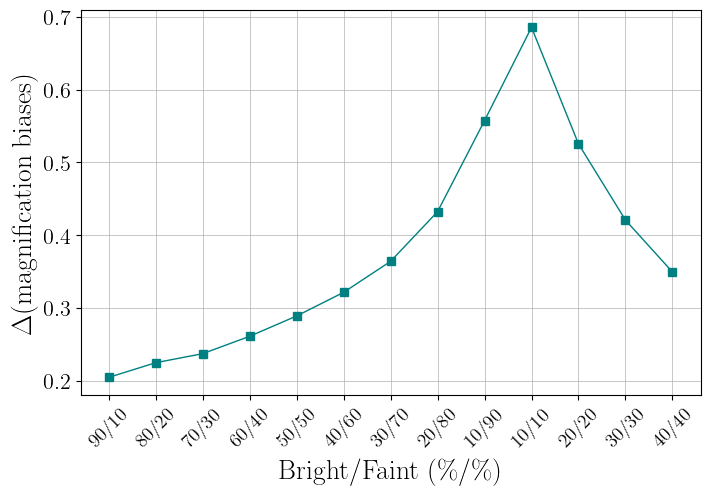

In [20]:
xticks = ['90/10','80/20','70/30','60/40','50/50','40/60','30/70','20/80','10/90','10/10','20/20','30/30','40/40']
x = range(len(xticks))

plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.grid(zorder=0,lw=0.5)
ax.set_xlabel(r'Bright/Faint (\%/\%)')
ax.set_ylabel(r'$\Delta$(magnification biases)')

#ax.axvspan(7.7, 9.3, color='gold', alpha=0.5)
ax.plot(x,ds,lw=1,marker='s',ms=6,color='teal')
ax.set_xticks(x,xticks,rotation=45)
    
plt.savefig('/global/homes/j/jpiat/Relativistic_effects/figures/delta_s.pdf',bbox_inches='tight');

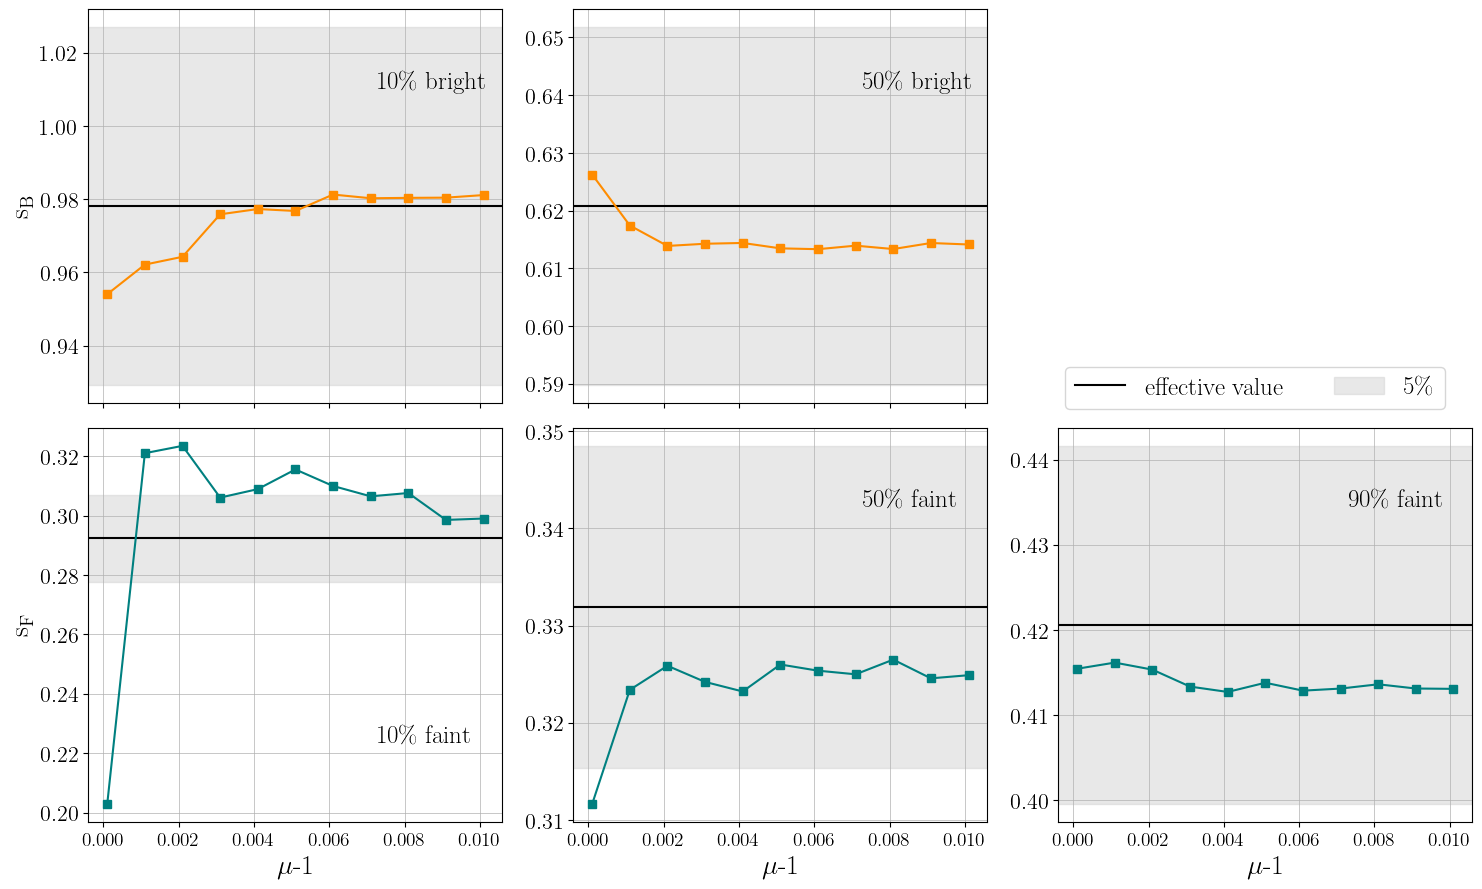

In [23]:
cut_bright = [10,50,10]
cut_faint = [10,50,90]
    
    
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(15, 9))
axes[0][2].set_visible(False)
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
#plt.subplots_adjust(hspace=0)
axes[0,0].set_ylabel(r's$_{\rm B}$',fontsize=20)
axes[1,0].set_ylabel(r's$_{\rm F}$',fontsize=20)

    
for k,(cut_b, cut_f) in enumerate(zip(cut_bright, cut_faint)):
    
    z_bins = np.linspace(0, 0.5, n_bins+1)
    z_means = np.zeros(n_bins)
    m_cuts_b = np.zeros(n_bins)
    m_cuts_f = np.zeros(n_bins)
        
    
    for i in range(n_bins):
        if i==(n_bins-1):
            bin = (z_g>=z_bins[i])*(z_g<=z_bins[i+1])
        else:
            bin = (z_g>=z_bins[i])*(z_g<z_bins[i+1])
    
        mi = m[bin]
        zi = z_g[bin]
        
        z_means[i] = np.mean(zi)
        
        m_cut_b = np.percentile(mi,cut_b)
        m_cut_f = np.percentile(mi,100-cut_f)
        m_cuts_b[i] = m_cut_b
        m_cuts_f[i] = m_cut_f
    
    
    m_interp_b = CubicSpline(z_means, m_cuts_b, extrapolate=True)
    m_interp_f = CubicSpline(z_means, m_cuts_f, extrapolate=True)
    
    cond_b = (m<=m_interp_b(z_g))
    cond_f = (m>m_interp_f(z_g))
    
    m_b = m[cond_b]
    m_f = m[cond_f]
    
    
    mu = np.arange(1.0001,1.011,0.001)
    sb = np.zeros(len(mu))
    sf = np.zeros(len(mu))
    
    sb_eff, sf_eff = s_eff(m,z_g,cut_b,cut_f)
    
    for j,mu_j in enumerate(mu):
        
        m_mag = m_tot - 2.5*np.log10(mu_j)
        
        cond_mag = (np.isnan(m_tot)==False)*(m_mag<=m_lim)*(z_tot<=z_max)
        m_mag = m_mag[cond_mag]
        z_g_mag = z_tot[cond_mag]
        
        cond_b_mag = (m_mag<=m_interp_b(z_g_mag))
        cond_f_mag = (m_mag>m_interp_f(z_g_mag))
    
        m_b_mag = m_mag[cond_b_mag]
        m_f_mag = m_mag[cond_f_mag]
        
        dm_b = abs(len(m_b_mag) - len(m_b))/len(m_b)
        s_b = 0.4*dm_b*1/(mu_j-1)
        
        dm_f = abs(len(m_f_mag) - len(m_f))/len(m_f)
        s_f = 0.4*dm_f*1/(mu_j-1)
        
        sb[j] = s_b
        sf[j] = s_f
        
        
    axes[1,k].set_xlabel(r'$\mu$-1',fontsize=20)
    axes[1,k].grid(zorder=0,lw=0.5)
    axes[0,k].grid(zorder=0,lw=0.5)
    
    if k == 0:
        axes[0,k].axhline(sb_eff,ls='-',color='k')
        axes[1,k].axhline(sf_eff,ls='-',color='k',label='effective value')
        axes[0,k].plot(mu-1,sb,c='darkorange',marker='s',ms=6)
        axes[1,k].plot(mu-1,sf,c='teal',marker='s',ms=6)
        axes[0,k].axhspan(sb_eff-0.05*sb_eff, sb_eff+0.05*sb_eff, color='lightgray', alpha=0.5)
        axes[1,k].axhspan(sf_eff-0.05*sf_eff, sf_eff+0.05*sf_eff, color='lightgray', alpha=0.5,label='5\%')
        
    else:
        axes[0,k].axhline(sb_eff,ls='-',color='k')
        axes[1,k].axhline(sf_eff,ls='-',color='k')
        axes[0,k].plot(mu-1,sb,c='darkorange',marker='s',ms=6)
        axes[1,k].plot(mu-1,sf,c='teal',marker='s',ms=6)
        axes[0,k].axhspan(sb_eff-0.05*sb_eff, sb_eff+0.05*sb_eff, color='lightgray', alpha=0.5)
        axes[1,k].axhspan(sf_eff-0.05*sf_eff, sf_eff+0.05*sf_eff, color='lightgray', alpha=0.5)
        
        
axes[0,1].text(0.7, 0.8, '50\% bright', fontsize=18,transform=axes[0,1].transAxes)
axes[1,1].text(0.7, 0.8, '50\% faint', fontsize=18,transform=axes[1,1].transAxes)
axes[0,0].text(0.7, 0.8, '10\% bright', fontsize=18,transform=axes[0,0].transAxes)
axes[1,0].text(0.7, 0.2, '10\% faint', fontsize=18,transform=axes[1,0].transAxes)
axes[1,2].text(0.7, 0.8, '90\% faint', fontsize=18,transform=axes[1,2].transAxes)

        
handles0, labels0 = axes[0,0].get_legend_handles_labels()
handles1, labels1 = axes[1,0].get_legend_handles_labels()
handles = handles0+handles1
labels = labels0+labels1
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.84, 0.6), fontsize=18, ncol=4)

plt.tight_layout()

    
plt.savefig('/global/homes/j/jpiat/Relativistic_effects/figures/convergence.pdf');

In [22]:
from astropy.table import Table

cuts = [10,50,90]
    
path = '/pscratch/sd/j/jpiat/Abacus/Ab_c000_ph006/z0.200/Split/BGS/'
           
for cut in cuts:
    
    file = path+f'cutsky_real_zmax0.5_m19.5_faint_{cut}.fits'
    
    sky = Table.read(file)

    print(len(sky))

3074790
15385128
27712057
